In [117]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label, binary_fill_holes
from skimage.measure import perimeter

In [118]:
# packages needed for animation
from IPython.display import clear_output, display, HTML
from IPython.display import HTML
from matplotlib.colors import ListedColormap
import tqdm

In [119]:
# full prelim CPM (Hamiltonian with deltaH_area & deltaH_perimeter & prelim deltaH_lum)

class CPM:
    def __init__(self, grid_size, num_cells, target_area, target_ratio, temperature, initialization, light_pattern):
        self.grid_size = grid_size
        self.num_cells = num_cells
        self.target_area = target_area
        self.target_ratio = target_ratio
        self.temperature = temperature
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.mc_time = 0
        self.gill_time = 0.0
        
        # initialize light pattern
        if light_pattern is not None:
            light_pattern = np.array(light_pattern, dtype=int) # make a numpy array, necessary for masking later on
            assert light_pattern.shape == (grid_size, grid_size), "light_pattern must match grid size"
            assert np.all(np.isin(light_pattern, [0, 1])), "light_pattern must be binary (0s and 1s)"
            self.light_pattern = light_pattern
        else:
            self.light_pattern = np.zeros((grid_size, grid_size), dtype=int)  # default: all dark

        # initialize cells on grid (random, ideal, space_filling)
        if initialization == "random":
          self.initialize_cells_random()
        elif initialization == "ideal":
          self.initialize_cells_ideal()
        elif initialization == "space_filling":
          self.initialize_cells_space_filling()
        elif initialization == "voronoi":
          self.initialize_cells_voronoi()
        elif initialization == "custom1":
          self.initialize_cells_custom1()
        elif initialization == "custom2":
          self.initialize_cells_custom2()
        else:
          print("invalid initialization")

    # figure out a better (non-hard coded way) to create cell of approx. circular shape to start with

    ###### ALL INITILIZATIONS ######
    
    ## RANDOM ##
    def initialize_cells_random(self): #choose cell centers randomly
        cell_ids = range(1, self.num_cells + 1)

        # new implementation: randomly choose cell centers, can totally overwrite previous cell if a cell center is
        # repeatedly chosen, code should still work but num_cells value may be lower than highest cell ID
        for cell_id in cell_ids:
            y, x = random.randint(3, self.grid_size - 4), random.randint(3, self.grid_size - 4)
            # main square
            self.grid[y-2:y+3, x-2:x+3] = cell_id #[inclusive, exclusive)
            #sides
            self.grid[y-1:y+2, x-3] = cell_id # left
            self.grid[y-3, x-1:x+2] = cell_id # top
            self.grid[y-1:y+2, x+3] = cell_id # right
            self.grid[y+3, x-1:x+2] = cell_id # bottom

        #get new number of cells
        existing_cell_ids = np.unique(self.grid)
        existing_cell_ids = existing_cell_ids[existing_cell_ids != 0]
        self.num_cells = len(existing_cell_ids)
        

        # old implementation: always places centers on whitespace but can get stuck in while loop if no whitespace left
        """
        for cell_id in cell_ids:
            while True:
                y, x = random.randint(3, self.grid_size - 4), random.randint(3, self.grid_size - 4)
                if self.grid[y, x] == 0:
                    # main square
                    self.grid[y-2:y+3, x-2:x+3] = cell_id #[inclusive, exclusive)
                    #sides
                    self.grid[y-1:y+2, x-3] = cell_id # left
                    self.grid[y-3, x-1:x+2] = cell_id # top
                    self.grid[y-1:y+2, x+3] = cell_id # right
                    self.grid[y+3, x-1:x+2] = cell_id # bottom
                    break
        """

    ## IDEAL ##
    def initialize_cells_ideal(self): #choose cell centers such as to uniformly place cells across space
        cell_id = 1
        for y in range(3, self.grid_size - 3, 7):
            for x in range(3, self.grid_size - 3, 7):
                # main sqaure
                self.grid[y-2:y+3, x-2:x+3] = cell_id #[unclusive, exclusive]
                #sides
                self.grid[y-1:y+2, x-3] = cell_id # left
                self.grid[y-3, x-1:x+2] = cell_id # top
                self.grid[y-1:y+2, x+3] = cell_id # right
                self.grid[y+3, x-1:x+2] = cell_id # bottom

                cell_id += 1
    
    ## SPACE_FILLING ##            
    def initialize_cells_space_filling(self):
      self.initialize_cells_ideal() # build upon above, so cells are vaguely circular
      # iterate through all spaces, looking for empty ones
      while 0 in self.grid:
        for y in range(0, self.grid_size):
          for x in range(0, self.grid_size):
            #if empty
            if self.grid[y, x] == 0:
              new_cell_id = [0] # start empty lsit
              for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]: #look at IDs of all neighbors
                  nx, ny = (x + dx) , (y + dy)
                  if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size: #if neighbor has valid indices
                    if self.grid[ny, nx] != 0:
                      new_cell_id.append(self.grid[ny, nx])
              random_id = random.choice(new_cell_id) #choose new ID randomly
              self.grid[y, x] = random_id
    
    ## VORONOI ##
    def initialize_cells_voronoi(self):

        center_method = "uniform"

        if center_method == "uniform": # Generate cell centers with uniform spacing
          # Calculate spacing for uniform distribution
          num_rows = int(np.sqrt(self.num_cells))
          num_cols = int(np.ceil(self.num_cells / num_rows))
          spacing_y = int(self.grid_size / num_rows)  # Spacing in y direction
          spacing_x = int(self.grid_size / num_cols)  # Spacing in x direction

          # calulcate centers
          cell_centers = []
          cell_id = 1  # Start cell ID from 1

          for i in range(num_rows):
              for j in range(num_cols):
                  y = spacing_y // 2 + i * spacing_y
                  x = spacing_x // 2 + j * spacing_x
                  cell_centers.append((y, x))
                  cell_id += 1
                  if cell_id > self.num_cells:
                      break  # Stop if we've reached the desired number of cells
              if cell_id > self.num_cells:
                  break

        if center_method == "random": #Randomly choose cell centers:
          cell_ids = range(1, self.num_cells + 1)
          cell_centers = []
          for cell_id in cell_ids:
              y, x = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1) #random.randint [inclusive, inclusive]
              cell_centers.append((y, x))

        #Assign pixels to cell center
        for y in range(self.grid_size):
            for x in range(self.grid_size):
                min_dist = float('inf')
                closest_cell_id = 0
                for cell_id, (cy, cx) in enumerate(cell_centers, 1):  # Start cell_id from 1
                    dist = np.sqrt((y - cy)**2 + (x - cx)**2)
                    if dist < min_dist:
                        min_dist = dist
                        closest_cell_id = cell_id
                self.grid[y, x] = closest_cell_id
    
    ## CUSTOM (customize cell centers) ##
    def initialize_cells_custom1(self):        
        cell_ids = range(1, self.num_cells + 1)

        # specify cell centers
        cell_centers = [(1,1), (8,1), (1,8), (8,8)]
        
        # repeatedly chosen, code should still work but num_cells value may be lower than highest cell ID
        for cell_id, (y,x) in enumerate(cell_centers, 1):
            # y, x = random.randint(3, self.grid_size - 4), random.randint(3, self.grid_size - 4)
            # main square
            self.grid[y-2:y+3, x-2:x+3] = cell_id #[inclusive, exclusive)
            #sides
            self.grid[y-1:y+2, x-3] = cell_id # left
            self.grid[y-3, x-1:x+2] = cell_id # top
            self.grid[y-1:y+2, x+3] = cell_id # right
            self.grid[y+3, x-1:x+2] = cell_id # bottom

        #get new number of cells
        existing_cell_ids = np.unique(self.grid)
        existing_cell_ids = existing_cell_ids[existing_cell_ids != 0]
        self.num_cells = len(existing_cell_ids)

    ## CUSTOM (customize entire grid) ##
    def initialize_cells_custom2(self):
        custom_grid = [
            [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ]

        self.grid = np.array(custom_grid, dtype=int)

        existing_cell_ids = np.unique(self.grid)
        existing_cell_ids = existing_cell_ids[existing_cell_ids != 0]
        self.num_cells = len(existing_cell_ids)
        


    ###### ACTUAL FUNCTIONS ###### ==> FEATURES OF CELL

    # update to be skimage.measure.regionprops() perimeter
    def calculate_perimeter(self, cell_id):

        # skimage.measure.regionprops() perimeter
        binary_grid = (self.grid == cell_id)
        perimeter_value = perimeter(binary_grid, neighborhood = 8)

        return perimeter_value

    def fraction_illuminated(self, cell_id):

        cell_mask = (self.grid == cell_id) # t/f mask of cell location
        light_mask = (self.light_pattern == 1) # t/f mask of light location
        
        overlap = cell_mask & light_mask # AND of both masks, where both true

        area_in_light = np.sum(overlap)
        total_area = np.sum(cell_mask)
        
        if total_area == 0:
            return 0.0
        return area_in_light / total_area


    ###### ACTUAL FUNCTIONS ###### ==> HAMILTONIAN & STEP METHODS
    
    def calculate_hamiltonian(self):
        hamiltonian = 0
        cell_ids = np.unique(self.grid)
        cell_ids = cell_ids[cell_ids != 0]
        
        for cell_id in cell_ids:
            # deltaH_ground: Check for disjoint parts
            labeled_array, num_features = label(self.grid == cell_id)
            if num_features > 1:
               return np.inf  # Negative infinity for disjoint parts

            # calc area & perimeter
            area = np.sum(self.grid == cell_id)
            perimeter = self.calculate_perimeter(cell_id)
            
            # calc portion covered by light

            # Energy terms for area and perimeter/area ratio
            hamiltonian += 0.2*np.abs(area - self.target_area) # deltaH_area
            hamiltonian += 0.8*(np.abs(((area**(1/2)) / perimeter) - self.target_ratio)) # deltaH_area/perimeter_ratio
            hamiltonian -= self.fraction_illuminated(cell_id)  # no specific deltaH term as outlined in JP, but deltaH_lum for now

        return hamiltonian


    def monte_carlo_step(self):
        for _ in range(self.grid_size**2):  # N random grid points
            i_x, i_y = random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)
            dx, dy = random.choice([(1, 0), (-1, 0), (0, 1), (0, -1)])
            j_x, j_y = (i_x + dx), (i_y + dy)

            # if jx,jy is a valid grid point (no wrapping around)
            if (0 <= j_x < self.grid_size) & (0 <= j_y < self.grid_size):
                #if xi,xj and jx,jy have different cell IDs
                if (self.grid[i_y, i_x] != self.grid[j_y, j_x]):

                  #old hamiltonian with old j ID
                  old_j_value = self.grid[j_y, j_x]
                  old_hamiltonian = self.calculate_hamiltonian()

                  # change j to i, calculate new hamiltonian
                  self.grid[j_y, j_x] = self.grid[i_y, i_x]
                  new_hamiltonian = self.calculate_hamiltonian()

                  # deltaH
                  delta_hamiltonian = new_hamiltonian - old_hamiltonian

                  if (delta_hamiltonian <= 0) or (random.random() < np.exp(-delta_hamiltonian / self.temperature)):
                      pass  # accept j -> i
                  else:
                      self.grid[j_y, j_x] = old_j_value  # reject j -> i
        self.mc_time += 1 #increment time by 1 every time one full monte carlo step is complete (all N events have been attempted)
    
    def gillespie_step(self):
        events = []
        rates = []

        # all possible copy events and their rates (probability of occuring)
        for i_y in range(self.grid_size):
            for i_x in range(self.grid_size):
                for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                    j_x, j_y = i_x + dx, i_y + dy
                    if 0 <= j_x < self.grid_size and 0 <= j_y < self.grid_size:
                        if self.grid[i_y, i_x] != self.grid[j_y, j_x]:
                            # calculate deltaH for this event
                            old_j_value = self.grid[j_y, j_x]
                            old_hamiltonian = self.calculate_hamiltonian()
                            self.grid[j_y, j_x] = self.grid[i_y, i_x]
                            new_hamiltonian = self.calculate_hamiltonian()
                            self.grid[j_y, j_x] = old_j_value  # revert

                            deltaH = new_hamiltonian - old_hamiltonian
                            # rate: exp(-deltaH/T) if deltaH > 0, else 1
                            if not np.isnan(deltaH):
                                rate = np.exp(-deltaH / self.temperature) #1.0
                            else:
                                print("deltaH is nan")
                            events.append(((i_x, i_y), (j_x, j_y)))
                            rates.append(rate)
        total_rate = np.sum(rates)
        if total_rate < 1e-12:  # every veryyyy unlikely (make it total_rate==0 causing NAN error)
            return  # no possible events

        # proportionally choose which event occurs
        print(events)
        print(rates)
        print(total_rate)
        
        chosen_index = np.random.choice(len(events), p=np.array(rates)/total_rate)
        (i_x, i_y), (j_x, j_y) = events[chosen_index]
        self.grid[j_y, j_x] = self.grid[i_y, i_x]

        # move forward in time, prbability of any event occuring (like aggregated poisson)
        # inverse transform sampling method
        U = np.random.uniform() #choose random number from uniform dist [0, 1) 
        delta_t = -np.log(U) / total_rate # waiting time for next event is expential; adds up to poisson process over many events
        self.gill_time += delta_t
      

In [120]:
# define a light pattern array for 21x21 testing

zero_light = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

half_light = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

corner_light = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]


In [130]:
# GILLESPIE STEPS

grid_size = 21
num_cells = 30 #relevant if using initialize_cells_random or initiliaze_cells_voronoi when constructing CPM
target_area = 37 #49 #37
target_ratio = 0.2534 #0.2917 #0.2534 #sqrt(area)/perimeter
temperature = 0.01

cpm = CPM(grid_size, num_cells, target_area, target_ratio, temperature, "ideal", corner_light)

# custom colormap
num_colors = np.max(cpm.grid)
random_colors = np.random.rand(num_colors + 1, 3)  # random rbg values
random_colors[0, :] = [1, 1, 1] #set background color to white

cmap = ListedColormap(random_colors) #create colormap

max_time = 100000000 # run until gill_time < 10
frames_for_plot = [cpm.grid.copy()] # intiilize with first frame
event_times = [cpm.gill_time] #initialize with first tim

with tqdm.tqdm(total=max_time, desc="Simulation Time") as pbar:
    while cpm.gill_time < max_time:
        prev_time = cpm.gill_time
        cpm.gillespie_step()
        event_times.append(cpm.gill_time)
        print(f"Time: {cpm.gill_time}")
        frames_for_plot.append(cpm.grid.copy())
        # Update progress bar by the time increment
        pbar.update(cpm.gill_time - prev_time)
    
# if i want to only save certain times, e.g. approx. every 0.5 time units:
# comment out above while loop before running below while loop
"""
frame_interval = 0.5  # how often to save a frame (in simulation time units)
next_frame_time = frame_interval

while cpm.gill_time < max_time:
    cpm.gillespie_step()
    event_times.append(cpm.gill_time)
    # Save a frame every frame_interval units of simulation time
    if cpm.gill_time >= next_frame_time:
        frames_for_plot.append(cpm.grid.copy())
        next_frame_time += frame_interval
"""

# Now animate the collected frames
fig, ax = plt.subplots()
image = ax.imshow(frames_for_plot[0], cmap=cmap, interpolation='nearest')

def update(frame):
    image.set_array(frames_for_plot[frame])
    ax.set_title(f"Time: {event_times[frame]:.5f}")
    return image,

ani = FuncAnimation(fig, update, frames=len(frames_for_plot), interval=400, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())


Simulation Time:   4%|▎         | 3734794.725047916/100000000 [00:01<00:51, 1870886.17it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   5%|▍         | 4962217.52432574/100000000 [00:05<01:59, 797103.73it/s]  

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   7%|▋         | 6602668.714842553/100000000 [00:08<02:12, 706255.92it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   7%|▋         | 7374376.087815163/100000000 [00:10<02:44, 563836.55it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   8%|▊         | 7680216.224189015/100000000 [00:13<03:43, 413805.46it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   9%|▉         | 8901612.244827304/100000000 [00:15<03:28, 436508.14it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   9%|▉         | 8951020.530273946/100000000 [00:18<05:06, 296743.12it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:   9%|▉         | 9212046.428607695/100000000 [00:20<06:22, 237500.97it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  10%|▉         | 9829427.779390395/100000000 [00:23<06:23, 234937.16it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  10%|█         | 10340653.87361678/100000000 [00:26<06:44, 221468.68it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  12%|█▏        | 11760701.561894832/100000000 [00:28<04:37, 317686.54it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  13%|█▎        | 13049730.224351738/100000000 [00:31<03:55, 369736.09it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  15%|█▍        | 14539719.131386185/100000000 [00:34<03:28, 409691.66it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  15%|█▍        | 14721705.173219511/100000000 [00:37<04:32, 313497.25it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  17%|█▋        | 16557519.354075255/100000000 [00:39<03:21, 413714.31it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  17%|█▋        | 16963809.48372296/100000000 [00:42<04:04, 339487.86it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  18%|█▊        | 17756077.807539776/100000000 [00:45<04:14, 323309.36it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  18%|█▊        | 17819517.53409336/100000000 [00:47<05:51, 234104.75it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  21%|██▏       | 21309897.28091728/100000000 [00:51<02:32, 514360.58it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  21%|██▏       | 21485613.347029354/100000000 [00:53<03:21, 390585.09it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  25%|██▌       | 25484609.503203273/100000000 [00:56<01:45, 703809.26it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  27%|██▋       | 26777352.86476834/100000000 [00:59<01:54, 642029.05it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  28%|██▊       | 27818057.006591383/100000000 [01:02<02:07, 566913.57it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  28%|██▊       | 28076321.08925011/100000000 [01:04<02:49, 424928.13it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  28%|██▊       | 28140503.805955827/100000000 [01:07<03:59, 299751.61it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (8, 1)), ((7, 1), (7, 2)), ((8, 1), (7, 1)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((13, 1), (13, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((7, 2), (7, 1)), ((13, 2), (14, 2)), ((13, 2), (13, 1)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7

Simulation Time:  29%|██▉       | 28895118.372924816/100000000 [01:10<04:00, 296095.44it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((7, 0), (7, 1)), ((8, 0), (9, 0)), ((8, 0), (8, 1)), ((9, 0), (8, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (7, 1)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (6, 1)), ((7, 1), (7, 0)), ((8, 1), (8, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (

Simulation Time:  31%|███       | 30850733.942731645/100000000 [01:13<02:46, 414110.49it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((12, 0), (12, 1)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (7, 1)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((7, 1), (6, 1)), ((7, 1), (7, 0)), ((12, 1), (13, 1)), ((12, 1), (12, 0)), ((13, 1), (12, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  31%|███▏      | 31370606.626278643/100000000 [01:15<03:14, 352509.13it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  33%|███▎      | 32651509.211863335/100000000 [01:18<02:55, 383815.08it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  34%|███▍      | 34124089.78065918/100000000 [01:21<02:37, 419022.02it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  39%|███▉      | 39337885.29275583/100000000 [01:24<01:10, 864372.47it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  40%|███▉      | 39669358.79445808/100000000 [01:26<01:32, 653932.26it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  41%|████      | 40662777.51657761/100000000 [01:29<01:47, 554074.02it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (6, 1)), ((7, 0), (8, 0)), ((7, 0), (7, 1)), ((8, 0), (7, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((7, 1), (7, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  42%|████▏     | 42176410.62846971/100000000 [01:32<01:42, 563513.27it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (7, 0)), ((6, 0), (6, 1)), ((7, 0), (6, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((5, 1), (6, 1)), ((5, 1), (5, 0)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  43%|████▎     | 43492737.66128017/100000000 [01:35<01:45, 537614.37it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((6, 0), (7, 0)), ((6, 0), (6, 1)), ((7, 0), (6, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  44%|████▍     | 44311370.6510436/100000000 [01:37<01:56, 478028.31it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((6, 0), (7, 0)), ((6, 0), (6, 1)), ((7, 0), (6, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((6, 1), (6, 0)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), 

Simulation Time:  46%|████▌     | 46233300.4521021/100000000 [01:40<01:39, 540903.93it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  49%|████▉     | 48808016.52029511/100000000 [01:43<01:16, 668766.36it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  50%|████▉     | 49849153.58291129/100000000 [01:45<01:26, 580289.45it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  50%|█████     | 50106268.10298467/100000000 [01:48<01:53, 441357.86it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  50%|█████     | 50451884.85947409/100000000 [01:51<02:26, 339011.88it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (6, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (5, 1)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 2)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((12, 2), (13, 2)), ((12, 2), (12, 1)), ((13, 2), (14, 2)), ((13, 2), (12, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3

Simulation Time:  53%|█████▎    | 53437857.22979245/100000000 [01:53<01:22, 564801.35it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  56%|█████▋    | 56496646.370584294/100000000 [01:57<01:02, 692662.32it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  57%|█████▋    | 56721831.65391054/100000000 [02:00<01:31, 475200.32it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  57%|█████▋    | 57160569.38604355/100000000 [02:04<01:59, 358287.23it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  62%|██████▏   | 62001609.744649775/100000000 [02:07<00:56, 673835.70it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  64%|██████▍   | 63982873.70131452/100000000 [02:11<00:55, 651808.90it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (6, 0)), ((5, 0), (4, 0)), ((5, 0), (5, 1)), ((6, 0), (5, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((5, 1), (5, 0)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((13, 2), (13, 3)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (12, 4)), ((12, 3

Simulation Time:  64%|██████▍   | 64108364.5437656/100000000 [02:13<01:11, 501264.81it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (13, 3)), ((12, 3), (12, 4)), ((12, 3), (12, 2)), ((13, 3), (14, 3)), ((13, 3), (12, 3)), ((14, 3), (13, 3)),

Simulation Time:  65%|██████▍   | 64500394.03750373/100000000 [02:16<01:29, 398830.26it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (13, 3)), ((12, 3), (12, 4)), ((12, 3), (12, 2)), ((13, 3), (14, 3)), ((13, 3), (12, 3)), ((14, 3), (13, 3)),

Simulation Time:  66%|██████▌   | 65607590.362601385/100000000 [02:19<01:24, 407607.39it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (13, 3)), ((12, 3), (12, 4)), ((12, 3), (12, 2)), ((13, 3), (14, 3)), ((13, 3), (12, 3)), ((14, 3), (13, 3)),

Simulation Time:  66%|██████▌   | 65665865.379798196/100000000 [02:22<01:57, 292557.26it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (13, 3)), ((12, 3), (12, 4)), ((12, 3), (12, 2)), ((13, 3), (14, 3)), ((13, 3), (12, 3)), ((14, 3), (13, 3)),

Simulation Time:  66%|██████▌   | 65730086.1536842/100000000 [02:24<02:36, 219524.01it/s]  

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((12, 2), (12, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (11, 4)), ((12, 3), (13, 3)), ((12, 3), (12, 4)), ((12, 3), (12, 2)), ((13, 3), (14, 3)), ((13, 3), (12, 3)), ((14, 3), (13, 3)),

Simulation Time:  66%|██████▌   | 66005007.34558015/100000000 [02:27<03:09, 179730.03it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((12, 2), (11, 2)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 4)), ((12, 3), (11, 3)), ((13, 3), (14, 3)), ((14, 3), (13, 3)), ((6, 4), (7, 4)), ((6, 4), (6, 5)), ((7, 4), (6, 4)), ((10,

Simulation Time:  68%|██████▊   | 67973872.42870013/100000000 [02:30<01:35, 336798.01it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((11, 2), (11, 3)), ((12, 2), (11, 2)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((10, 3), (11, 3)), ((11, 3), (10, 3)), ((11, 3), (11, 2)), ((13, 3), (14, 3)), ((14, 3), (13, 3)),

Simulation Time:  68%|██████▊   | 68045433.55038534/100000000 [02:33<02:09, 246444.91it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((11, 2), (11, 3)), ((12, 2), (11, 2)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((10, 3), (11, 3)), ((11, 3), (10, 3)), ((11, 3), (11, 2)), ((13, 3), (14, 3)), ((14, 3), (13, 3)),

Simulation Time:  69%|██████▉   | 68972457.35038137/100000000 [02:35<01:53, 272362.41it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((12, 1), (11, 1)), ((12, 1), (12, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((11, 2), (12, 2)), ((11, 2), (11, 3)), ((12, 2), (11, 2)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((10, 3), (11, 3)), ((11, 3), (10, 3)), ((11, 3), (11, 2)), ((13, 3), (14, 3)), ((14, 3), (13, 3)),

Simulation Time:  70%|██████▉   | 69544808.02655767/100000000 [02:38<01:59, 254920.09it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((11, 1), (12, 1)), ((11, 1), (11, 2)), ((12, 1), (11, 1)), ((12, 1), (12, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 1)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((10, 3), (11, 3)), ((11, 3), (10, 3)), ((11, 3), (11, 4)), ((13, 3), (14, 3)),

Simulation Time:  71%|███████▏  | 71351375.79256383/100000000 [02:44<01:42, 280370.65it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((10, 3), (11, 3)), ((11, 3), (10, 3)), ((11, 3), (11, 4)), ((13, 3), (14, 3)),

Simulation Time:  76%|███████▋  | 76438772.44121285/100000000 [02:47<00:35, 660843.99it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((15, 0), (16, 0)), ((15, 0), (15, 1)), ((16, 0), (15, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((14, 1), (15, 1)), ((14, 1), (14, 2)), ((15, 1), (14, 1)), ((15, 1), (15, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((14, 2), (14, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)), ((13, 3), (14, 3)), ((14, 3), (13, 3)),

Simulation Time:  78%|███████▊  | 78252078.7836987/100000000 [02:49<00:32, 660678.78it/s] 

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  80%|███████▉  | 79902914.83896208/100000000 [02:52<00:31, 633096.65it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  81%|████████  | 81084521.22528213/100000000 [02:55<00:33, 573014.06it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  81%|████████▏ | 81267384.69329354/100000000 [02:58<00:44, 424800.35it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  81%|████████▏ | 81489588.86880086/100000000 [03:01<00:57, 324449.98it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  82%|████████▏ | 82032429.46175578/100000000 [03:04<01:04, 279813.22it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  84%|████████▎ | 83678489.75110662/100000000 [03:07<00:44, 370810.78it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  86%|████████▌ | 85853288.44305974/100000000 [03:10<00:29, 487075.85it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  87%|████████▋ | 86872705.20545596/100000000 [03:12<00:28, 454319.41it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  88%|████████▊ | 87712154.64868614/100000000 [03:15<00:30, 399438.85it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  89%|████████▉ | 88874116.212991/100000000 [03:18<00:27, 399882.77it/s]  

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  93%|█████████▎| 92546779.01792428/100000000 [03:21<00:11, 662232.33it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  93%|█████████▎| 92850497.30448344/100000000 [03:24<00:14, 483434.32it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  94%|█████████▍| 94261709.90803508/100000000 [03:28<00:12, 457719.99it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  95%|█████████▍| 94982237.40855964/100000000 [03:31<00:12, 390289.09it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  95%|█████████▌| 95227808.36109215/100000000 [03:34<00:16, 286530.87it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  95%|█████████▌| 95421150.45661403/100000000 [03:38<00:22, 199804.74it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (11, 1)), ((12, 0), (13, 0)), ((12, 0), (12, 1)), ((13, 0), (12, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((12, 1), (12, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time:  96%|█████████▌| 95813580.91344845/100000000 [03:42<00:24, 169248.45it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((15, 0), (15, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((18, 0), (19, 0)), ((19, 0), (18, 0)), ((19, 0), (19, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (15, 0)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((19, 1), (19, 0)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

Simulation Time:  96%|█████████▌| 95922693.50896138/100000000 [03:45<00:29, 136167.69it/s]

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((11, 0), (12, 0)), ((11, 0), (11, 1)), ((12, 0), (11, 0)), ((14, 0), (14, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((19, 0), (20, 0)), ((20, 0), (19, 0)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((11, 1), (11, 0)), ((13, 1), (14, 1)), ((14, 1), (15, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (16, 1)), ((15, 1), (14, 1)), ((15, 1), (15, 2)), ((16, 1), (15, 1)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((15, 2), (15, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)),

Simulation Time: 100042951.93490282it [03:51, 431503.58it/s]                              

[((1, 0), (2, 0)), ((1, 0), (1, 1)), ((2, 0), (1, 0)), ((4, 0), (5, 0)), ((5, 0), (4, 0)), ((10, 0), (11, 0)), ((11, 0), (10, 0)), ((14, 0), (14, 1)), ((16, 0), (17, 0)), ((16, 0), (16, 1)), ((17, 0), (16, 0)), ((19, 0), (20, 0)), ((20, 0), (19, 0)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((1, 1), (0, 1)), ((1, 1), (1, 0)), ((4, 1), (5, 1)), ((5, 1), (4, 1)), ((5, 1), (5, 2)), ((6, 1), (6, 2)), ((10, 1), (11, 1)), ((11, 1), (10, 1)), ((13, 1), (14, 1)), ((14, 1), (15, 1)), ((14, 1), (13, 1)), ((14, 1), (14, 0)), ((15, 1), (16, 1)), ((15, 1), (14, 1)), ((15, 1), (15, 2)), ((16, 1), (15, 1)), ((16, 1), (16, 0)), ((19, 1), (20, 1)), ((20, 1), (19, 1)), ((20, 1), (20, 2)), ((0, 2), (0, 1)), ((5, 2), (5, 1)), ((6, 2), (7, 2)), ((6, 2), (6, 1)), ((7, 2), (6, 2)), ((10, 2), (11, 2)), ((11, 2), (10, 2)), ((11, 2), (11, 3)), ((13, 2), (14, 2)), ((14, 2), (13, 2)), ((15, 2), (15, 1)), ((20, 2), (20, 1)), ((6, 3), (7, 3)), ((7, 3), (6, 3)), ((11, 3), (12, 3)), ((11, 3), (11, 2)), ((12, 3), (11, 3)),

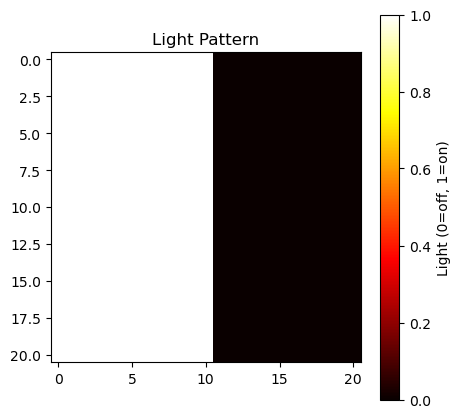

In [125]:
# visualize light pattern
plt.figure(figsize=(5, 5))
plt.imshow(cpm.light_pattern, cmap='hot', interpolation='nearest')
plt.title("Light Pattern")
plt.colorbar(label="Light (0=off, 1=on)")
plt.show()

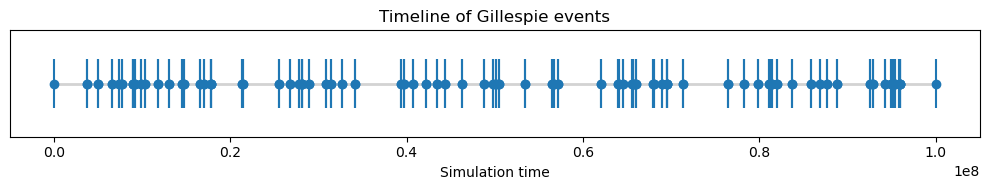

Average waiting time between events: 621384.7946


In [131]:
# plot event times (like timeline, every dot represents 1 event)
plt.figure(figsize=(10, 2))
plt.hlines(1, event_times[0], event_times[-1], color='lightgray', linewidth=2)  # timeline line
plt.eventplot(event_times, lineoffsets=1, colors='tab:blue', linelengths=0.3)
plt.scatter(event_times, [1]*len(event_times), color='tab:blue', zorder=3)
plt.yticks([])
plt.xlabel("Simulation time")
plt.title("Timeline of Gillespie events")
plt.tight_layout()
plt.show()

#get avg waiting time
waiting_times = np.diff(event_times)
avg_waiting_time = np.mean(waiting_times)
print(f"Average waiting time between events: {avg_waiting_time:.4f}")

In [ ]:
# MONTE CARLO STEPS

# create + animate ex. of above
# this will take a few minutes to run(~4 minutes for num_cells = 50, frames = 10, grid size big enough to accomodate 50 cells)

grid_size = 21
num_cells = 5 #relevant if using initialize_cells_random or initiliaze_cells_voronoi when constructing CPM
target_area = 49 #37
target_ratio = 0.2917 #0.2534 #sqrt(area)/perimeter
temperature = 0.3
frames = 20

cpm = CPM(grid_size, num_cells, target_area, target_ratio, temperature, "space_filling")

# custom colormap
num_colors = np.max(cpm.grid)
random_colors = np.random.rand(num_colors + 1, 3)  # random rbg values
#random_colors[0, :] = [1, 1, 1] #set background color to white

cmap = ListedColormap(random_colors) #create colormap

fig, ax = plt.subplots()
image = ax.imshow(cpm.grid.copy(), cmap=cmap, interpolation='nearest')

frames_for_plot = [cpm.grid.copy()]

event_times = []  # to store the times at which events occur

def update(frame):
    """Updates the animation for each frame."""
    if frame > 0: #make sure to capture initial frame
      cpm.monte_carlo_step()  # perform one step (monte carlo or gillespie)
      frames_for_plot.append(cpm.grid.copy())
      event_times.append(cpm.mc_time) # keep track of event occurence times
    image.set_array(cpm.grid)  # set now image onto grid
    ax.set_title(f"Time step: {cpm.mc_time}") # add time step at top

    # return updated/new image
    return image, #FuncAnimation expects an iterable from "update" so make image a tuple: image,

# animation object
ani = FuncAnimation(fig, update, frames=frames, interval=400, blit=True)

# display animation object
plt.close(fig)  # close last frame
HTML(ani.to_jshtml())

In [ ]:
# Create a 2x2 plot of the first four frames
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    axes[i].imshow(frames_for_plot[i], cmap=cmap, interpolation='nearest')
    axes[i].set_title(f"Frame {i + 1}")

plt.tight_layout()
plt.show()

In [ ]:
# Create a 5x5 plot of the first 16 frames
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(frames_for_plot[i], cmap=cmap, interpolation='nearest')
    axes[i].set_title(f"Frame {i + 1}")

plt.tight_layout()
plt.show()

In [128]:
#%pip install ffmpeg-python
import ffmpeg
import matplotlib.animation as animation

In [132]:
# save animation to .mp4 file

fig, ax = plt.subplots()
image = ax.imshow(frames_for_plot[0], cmap=cmap, interpolation='nearest')

def update(frame):
    image.set_array(frames_for_plot[frame])
    return image,

ani = animation.FuncAnimation(fig, update, frames=len(frames_for_plot), interval=200, blit=True)
ani.save('gill_corner_light1.mp4', writer=animation.FFMpegWriter(fps=5))
plt.close(fig)